In [ ]:
%matplotlib inline
import sys

!pip install category_encoders==2.*

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [ ]:
df = pd.read_csv('/content/monthly economic data.csv', parse_dates=['date'], index_col='date')

In [ ]:
df.tail()

,ism_pmi,head_CPI,head_CPI_roc,head_CPI_bps,core_CPI,core_CPIyoy,CRB,10yr_rate,10yr_roc,per_chg_yoy,swiss10yr,swiss_roc,dxy,dxy_roc,ind_pro_man,wti,wti_roc_qoq,wti_yoy,ba_credit_spread,copper_fut,copper_chg_yoy,gold,gold_roc_qoq,gold_chg_yoy,copper/gold,silver,gold/silver,pmi,roc_pmi,rocpmi_bps,fed rate
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,41.5,255.902,0.376163,-114.216724,265.601,1.43831,117.20,0.64,-57.615894,-1.87,-0.487,-30.229226,99.57,2.238423,84.5913,16.55,-71.227399,-74.08393,1.697143,2.3055,-21.44009,1685.05,5.964659,33.58363,0.001368,14.973,112.539237,100.8026,-5.172839,-496.864463,0.05
2020-05-01,43.1,255.768,0.235532,-14.063049,265.441,1.23647,132.24,0.65,-42.477876,-1.49,-0.471,-43.389423,98.34,0.214002,87.8986,28.56,-43.490305,-53.04948,1.454000,2.4255,-12.92939,1728.30,9.032067,33.15201,0.001403,18.499,93.426672,84.5913,-19.722568,-1454.972961,0.05
2020-06-01,52.6,257.214,0.709470,47.393775,266.065,1.19426,137.97,0.66,-5.714286,-1.34,-0.439,19.293478,97.39,-1.675921,94.6167,38.31,31.153714,-29.91218,1.201818,2.7135,-2.16975,1780.67,13.323914,25.29720,0.001524,18.064,98.575620,87.8986,-16.685845,303.672364,0.08
2020-07-01,54.2,258.723,1.029338,31.986791,267.715,1.56609,143.69,0.55,-14.062500,-1.47,-0.529,8.624230,93.35,-6.246862,98.3754,40.71,145.981873,-29.01482,1.173182,2.8680,7.25890,1974.69,17.188807,38.03782,0.001452,24.216,81.544846,94.6167,-10.821074,586.477053,0.09
2020-08-01,56.0,259.681,1.321529,29.219150,268.747,1.72875,153.21,0.72,10.769231,-0.78,-0.410,-12.951168,92.14,-6.304657,99.3189,42.34,48.249300,-22.75132,1.024286,3.0410,13.99353,1968.03,13.870856,28.12224,0.001545,28.594,68.826677,98.3754,-6.918340,390.273402,0.10


In [ ]:
def wrangle(df):

  df = df.copy()
 
  # New Feature `Copper/Gold Ratio` & `Copper/WTI` Ratio
  df['Copper/WTI Ratio'] = df['copper_fut'] / df['wti']
  df['Copper/CRB Ratio'] = df['copper_fut'] / df['CRB']

  # New Feature using rolling correlation
  df['CD quarter corr'] = df['copper_fut'].rolling(4).corr(df['dxy'])
  df['CG quarter gold corr'] = df['copper_fut'].rolling(4).corr(df['gold'])
  df['CC quarter gold corr'] = df['copper_fut'].rolling(4).corr(df['CRB'])
  
  # New Features using rolling correlation
  df['DG quarter corr'] = df['dxy'].rolling(4).corr(df['gold'])
  df['DCRB quarter corr'] = df['dxy'].rolling(4).corr(df['CRB']) 

  # Creating NEW Target `CPI overall`
  result = [] 
  for value in df['head_CPI_bps']: 
    if value >= 0.00: 
      result.append("Accelerate")  
    else:
      result.append("Decelerate")

  df['CPI overall'] = result

 # Creating a NEW FEATURE `WTI_ROC +`
  result_wti_roc_up=[]
  for value in df['wti_roc_qoq']:
    if value >= 0.00:
      result_wti_roc_up.append('+')
    else:
      result_wti_roc_up.append('-')

  df['wti_roc_up'] = result_wti_roc_up

  # Creating a NEW FEATURE `WTI_yoy_Chg`
  result_wti_yoy=[]
  for value in df['wti_yoy']:
    if value >= 0.00:
      result_wti_yoy.append('+')
    else:
      result_wti_yoy.append('-')

  df['wti_yoy_up'] = result_wti_yoy

  # Creating a NEW FEATURE `Gold_ROC +`
  result_gold_roc_up=[]
  for value in df['gold_roc_qoq']:
    if value >= 0.00:
      result_gold_roc_up.append('-')
    else:
      result_gold_roc_up.append('+')

  df['gold_roc_up'] = result_gold_roc_up

  # Creating a NEW FEATURE `Gold_yoy_Chg`
  result_gold_yoy=[]
  for value in df['gold_chg_yoy']:
    if value >= 0.00:
      result_gold_yoy.append('-')
    else:
      result_gold_yoy.append('+')

  df['gold_yoy_up'] = result_gold_yoy

  # Dropping unimportant columns
  df = df.drop(['head_CPI_roc', 'head_CPI_bps', 'head_CPI', 'core_CPI', 
                'core_CPIyoy', 'pmi', 'rocpmi_bps', 'roc_pmi', 'wti_yoy_up', 'gold_yoy_up'],axis=1)                          
                # , 'ism_pmi', 'pmi', 'rocpmi_bps', 'roc_pmi, , 'ism_pmi', , 'Copper/CRB Ratio', 'gold', , 'gold_roc_qoq', 'wti_roc_qoq'
              
                
  # Dropping null values          
  df = df.dropna()

  return df


In [ ]:
# Applying wrangle function to DataFrame
df = wrangle(df)

In [ ]:
df.tail(20)

,ISM_PMI,Commodity_Index,10yr_Rate,10yr_ROC,10yr_yoy_Per_Chg,Swiss_10yr,Swiss_10yr_ROC,Dollar_Index,Dollar_ROC,Indust_Prod_Manufacturing,WTI,WTI_ROC,WTI_yoy_Chg,Aaa/Baa_Yield_Spread,Copper,Copper_yoy_Chg,Gold,Gold_ROC,Gold_yoy_Chg,Copper/Gold,Silver,Gold/Silver,Fed_Funds_Rate,Copper/WTI,Copper/CRB,Copper/$_Quarter_Corr,Copper/Gold_Quarter_Corr,Copper/CRB_Quarter_Corr,$/Gold_Quarter_Corr,$/CRB_Quarter_Corr,CPI_Direction,WTI_ROC_+,Gold_ROC_+,MA_12_ISM,MA_12_WTI,Aaa/Baa_Spread_Inv,MA_12_Aaa/Baa_Spread_Inv
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,56.6,179.64,2.63,-16.507937,-0.09,-0.210,-395.774648,95.58,-1.595799,106.8790,51.38,-27.378092,-19.34066,1.190000,2.8110,-15.94641,1320.94,8.760518,-1.55209,0.002128,16.022,82.445388,2.40,0.054710,0.015648,-0.192705,0.272242,0.146576,-0.991437,0.566363,Decelerate,-,-,NaN,NaN,-1.190000,NaN
2019-02-01,54.1,182.75,2.73,-9.302326,-0.14,-0.236,1473.333333,96.16,-1.141153,106.3204,54.95,-3.528792,-11.69854,1.157368,2.9620,-10.07686,1313.05,7.454417,0.39006,0.002256,15.538,84.505728,2.40,0.053904,0.016208,-0.084538,0.350867,0.864145,-0.952668,0.227437,Decelerate,-,-,NaN,NaN,-1.157368,NaN
2019-03-01,54.6,183.75,2.41,-10.408922,-0.33,-0.352,128.571429,97.28,1.154206,106.3014,58.15,17.427302,-7.30113,1.065714,2.9500,-5.29056,1292.15,0.727304,-2.47375,0.002283,15.295,84.481857,2.41,0.050731,0.016054,0.439107,0.430676,0.971541,-0.590240,0.358297,Accelerate,+,-,NaN,NaN,-1.065714,NaN
2019-04-01,53.4,184.25,2.51,-4.562738,-0.44,-0.267,27.142857,97.48,1.987864,105.3737,63.86,24.289607,-3.60755,1.013333,2.9200,-6.03006,1283.60,-2.826775,-2.36277,0.002275,15.069,85.181498,2.42,0.045725,0.015848,0.608997,-0.521257,0.851213,-0.991034,0.921844,Accelerate,+,+,NaN,NaN,-1.013333,NaN
2019-05-01,52.3,175.36,2.14,-21.611722,-0.69,-0.445,88.559322,97.75,1.653494,105.5026,60.83,10.700637,-13.07516,0.958182,2.6440,-11.82911,1305.65,-0.563573,-0.57537,0.002025,14.756,88.482651,2.39,0.043465,0.015078,-0.630793,-0.255201,0.965988,-0.572061,-0.427125,Decelerate,+,+,NaN,NaN,-0.958182,NaN
2019-06-01,51.6,181.04,2.00,-17.012448,-0.85,-0.482,36.931818,96.13,-1.182155,106.0976,54.66,-6.001720,-19.46368,1.040500,2.7200,-15.55634,1409.50,9.081763,13.00628,0.001930,15.447,91.247491,2.38,0.049762,0.015024,0.145870,-0.515158,0.914142,-0.923038,-0.229080,Decelerate,-,-,NaN,NaN,-1.040500,NaN
2019-07-01,51.3,178.53,2.02,-19.521912,-0.94,-0.654,144.943820,98.52,1.066886,105.6872,57.35,-10.194175,-19.20259,0.989091,2.6760,-4.95228,1413.80,10.143347,17.33514,0.001893,16.533,85.513821,2.40,0.046661,0.014989,-0.176743,-0.511339,0.915208,-0.126732,-0.372138,Accelerate,-,-,NaN,NaN,-0.989091,NaN
2019-08-01,48.8,170.36,1.50,-29.906542,-1.36,-0.975,119.101124,98.92,1.196931,106.3504,54.81,-9.896433,-19.46812,0.893636,2.5620,-5.64539,1520.25,16.436258,26.49045,0.001685,18.467,82.322521,2.13,0.046743,0.015039,-0.796214,-0.514053,0.996134,0.407212,-0.758508,Decelerate,-,-,NaN,NaN,-0.893636,NaN
2019-09-01,48.2,173.94,1.68,-16.000000,-1.37,-0.700,45.228216,99.38,3.380838,105.6556,56.95,4.189535,-18.90930,0.884500,2.5900,-4.81778,1472.25,4.451933,25.69497,0.001759,17.130,85.945709,2.04,0.045478,0.014890,-0.840729,-0.953847,0.987582,0.649048,-0.779656,Decelerate,+,-,NaN,NaN,-0.884500,NaN


In [ ]:
# More FEATURES rolling mean and shifting for time series correlation

df['MA12_ISM'] = df['ism_pmi'].rolling(window=12).mean().shift(-20)
df['MA12_WTI'] = df['wti'].rolling(window=12).mean().shift(-20)
df['inverse_ba'] = df['ba_credit_spread'] * -1
df['MA12_inverse_ba'] = df['inverse_ba'].rolling(window=12).mean().shift(-20)

In [ ]:
# Cleaning column names for feature importance readability 

df.columns = ['ISM_PMI', 'Commodity_Index', '10yr_Rate','10yr_ROC', '10yr_yoy_Per_Chg', 
              'Swiss_10yr', 'Swiss_10yr_ROC', 'Dollar_Index', 'Dollar_ROC',
              'Indust_Prod_Manufacturing', 'WTI', 'WTI_ROC', 'WTI_yoy_Chg', 
              'Aaa/Baa_Yield_Spread', 'Copper', 'Copper_yoy_Chg', 'Gold', 
              'Gold_ROC', 'Gold_yoy_Chg', 'Copper/Gold', 'Silver', 
              'Gold/Silver', 'Fed_Funds_Rate', 'Copper/WTI', 'Copper/CRB', 
              'Copper/$_Quarter_Corr', 'Copper/Gold_Quarter_Corr', 
              'Copper/CRB_Quarter_Corr', '$/Gold_Quarter_Corr', 
              '$/CRB_Quarter_Corr', 'CPI_Direction', 'WTI_ROC_+', 'Gold_ROC_+',
              'MA_12_ISM', 'MA_12_WTI', 'Aaa/Baa_Spread_Inv', 'MA_12_Aaa/Baa_Spread_Inv']

#Split target vector from feature matrix
#Split training and validation set

In [ ]:
# target is the `CPI_Direction`
# categorical
target = 'CPI_Direction'

y = df[target]
X = df.drop(target , axis=1)

In [ ]:
cutoff1 = '2017-07-01'
mask1 = (df.index <= cutoff1)
train = df[mask1]
val = df[~mask1]

In [ ]:
y_train = train[target]
X_train = train.drop([target], axis=1)

y_val = val[target]
X_val = val.drop(target, axis=1)

In [ ]:
y_train.value_counts()

Decelerate    145
Accelerate    134
Name: CPI_Direction, dtype: int64

In [ ]:
# Checking with assert
assert df.shape[0] == train.shape[0] + val.shape[0]

In [ ]:
# Baseline --> Classification

from sklearn.metrics import mean_absolute_error
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5197132616487455


In [ ]:
# Model 1: Logistic Regression

model = make_pipeline(
    OrdinalEncoder(),   
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()    
)

model.fit(X_train, y_train);

In [ ]:
print('Training Accuracy LOGR:', model.score(X_train, y_train))
print('Validtaion Accuracy LOGR:', model.score(X_val, y_val))

Training Accuracy LOGR: 0.6989247311827957
Validtaion Accuracy LOGR: 0.5945945945945946


In [ ]:
import numpy as np
coefficients = np.round(model.named_steps['logisticregression'].coef_, 3)
list(zip(X_train.columns, coefficients))

[('ISM_PMI',
  array([ 0.53 , -0.074,  0.761, -0.417, -0.864,  0.671,  0.067,  0.237,
          0.106,  0.242,  0.63 , -0.098, -0.736,  0.256, -0.32 ,  0.52 ,
          1.094, -0.153, -0.495,  0.219, -0.295,  0.426,  0.381, -0.342,
          0.305,  0.106,  0.062,  0.037, -0.065,  0.129, -0.018, -0.08 ,
          0.044,  0.166, -0.256,  0.074]))]

In [ ]:
# Model 2: Random Forest Classifier
model_f = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier(n_jobs=-1, n_estimators=20, random_state=42)
)

model_f.fit(X_train, y_train);

In [ ]:
print('Train Accuracy (RF):', model_f.score(X_train, y_train))
print('Validation Accuracy (RF):', model_f.score(X_val, y_val))

Train Accuracy (RF): 0.992831541218638
Validation Accuracy (RF): 0.7027027027027027


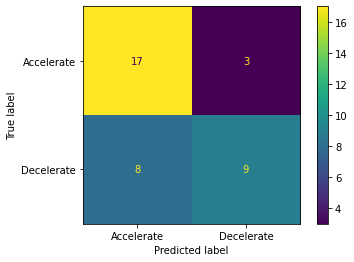

In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(model_f,
                      X_val, 
                      y_val,
                      display_labels=['Accelerate', 'Decelerate'],
                      values_format='.0f');

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor

In [ ]:
# Model 3: Gradient Boosting Classifier

model_grad = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(n_estimators=32)
)
model_grad.fit(X_train,y_train);

In [ ]:

print('Train Accuracy:', model_grad.score(X_train, y_train))
print('Validation Accuracy:', model_grad.score(X_val, y_val))

Train Accuracy: 0.9354838709677419
Validation Accuracy: 0.7297297297297297


Confusion Matrix

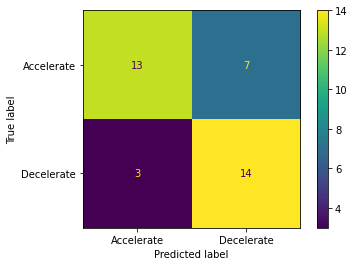

In [ ]:
# Gradient Boosting classification
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(model_grad,
                      X_val, 
                      y_val,
                      display_labels=['Accelerate', 'Decelerate'],
                      values_format='.0f');

In [ ]:
print(classification_report(y_val,model_grad.predict(X_val), target_names=['Accelerate','Decelerate']))

              precision    recall  f1-score   support

  Accelerate       0.81      0.65      0.72        20
  Decelerate       0.67      0.82      0.74        17

    accuracy                           0.73        37
   macro avg       0.74      0.74      0.73        37
weighted avg       0.75      0.73      0.73        37



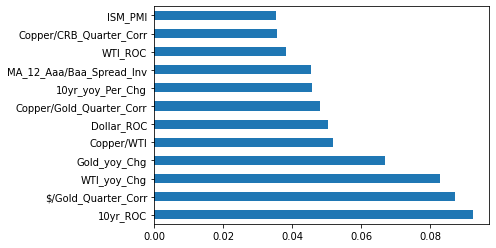

In [ ]:
# 1) Feature Importance for Gradient Boosting Classifier

feature_imp = model_grad.named_steps['gradientboostingclassifier'] .feature_importances_
features = X_train.columns

pd.Series(feature_imp, features).sort_values(ascending=False).head(12).plot(kind='barh');

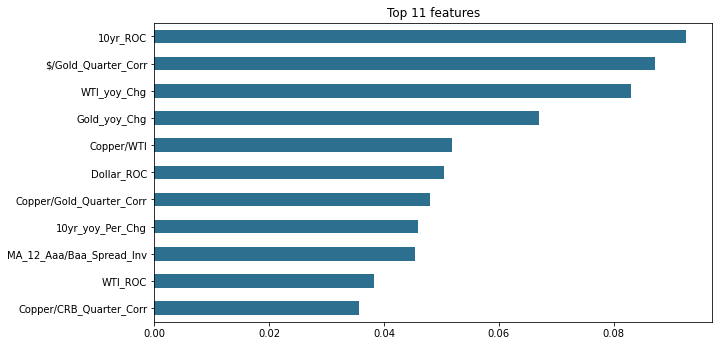

In [ ]:
# 2) Feature Importance for Gradient Boosting Classifier

gbc = model_grad.named_steps['gradientboostingclassifier']
importances = pd.Series(gbc.feature_importances_, X_train.columns)

n = 11
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='#2D6F8E');

#PDP Plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


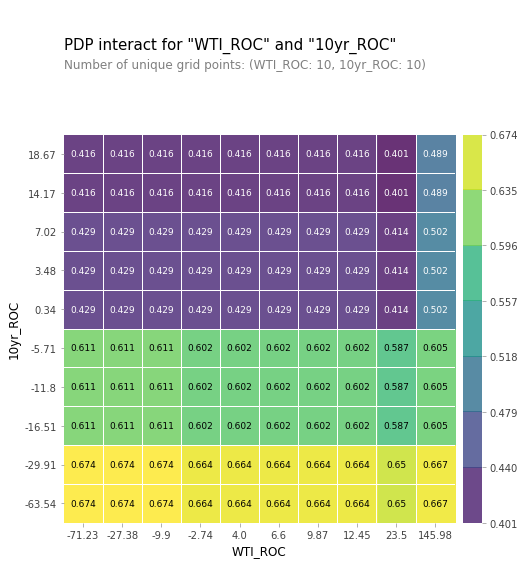

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot

features = ['WTI_ROC', '10yr_ROC']
interaction = pdp_interact(
    model=model_grad,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

While the rate of change in the price of WTI is highly negative the 10 year rate of change seems to have a higher effect on inflation accerlating as the 10 year rate of change increases. Futhermore, if the 10 year RoC remains elevated and the WTI RoC increaeses to the 23.5 level there is a shift to WTI RoC having a greater effect on inflation. Diving deeper into these thresholds could be an area for deeper investigation.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


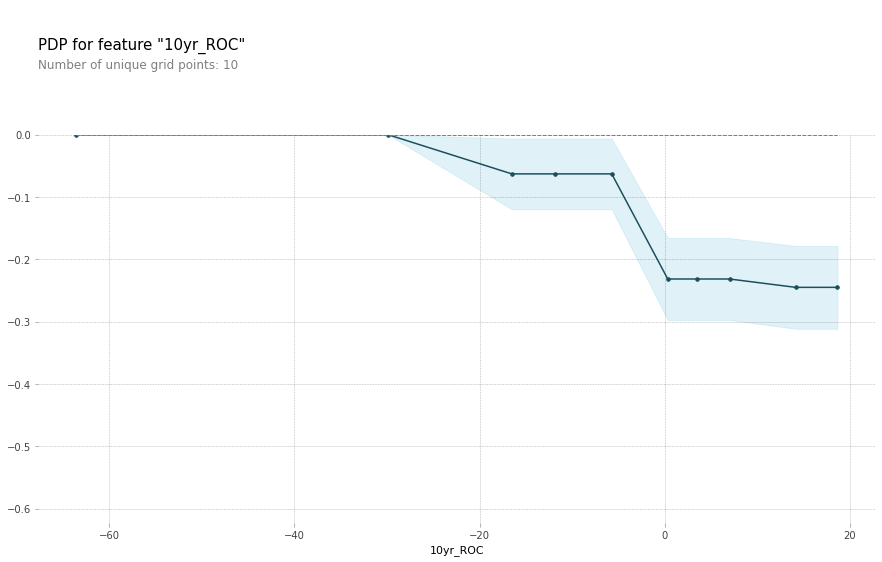

In [ ]:
# PDP isolated (One Single Feature)

plt.rcParams['figure.dpi'] = 72


feature = '10yr_ROC'
isolated = pdp_isolate(
    model=model_grad,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

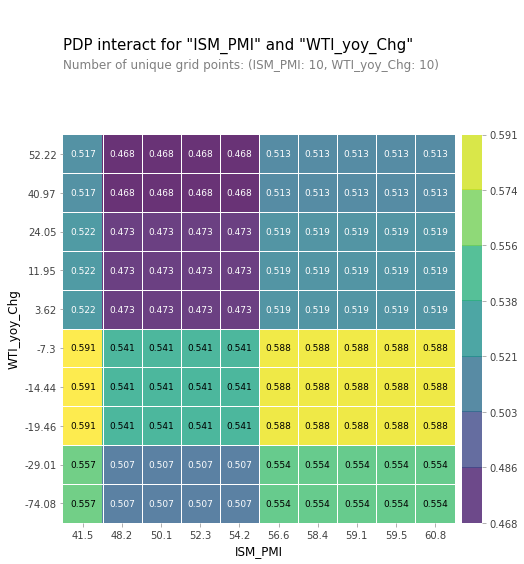

In [ ]:
# 2nd PDP Interact Plot

features = ['ISM_PMI', 'WTI_yoy_Chg']

interaction = pdp_interact(
    model=model_grad,
    dataset=X_val,
    model_features=X_train.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [ ]:
# Model 4: XGB Regressor

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    # SelectKBest(k=20),
    XGBClassifier(n_jobs=-1, n_estimators=23)
)

model_xgb.fit(X_train, y_train);

In [ ]:
print('Train Accuracy:', model_xgb.score(X_train, y_train))
print('Validation Accuracy:', model_xgb.score(X_val, y_val)) 

Train Accuracy: 0.8960573476702509
Validation Accuracy: 0.7027027027027027


Confusion Matrix XGB Regression

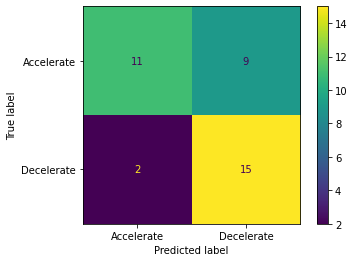

In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(model_xgb,
                      X_val, 
                      y_val,
                      display_labels=['Accelerate', 'Decelerate'],
                      values_format='.0f')

In [ ]:
print(classification_report(y_val,model_xgb.predict(X_val), target_names=['Accelerate','Decelerate']))

              precision    recall  f1-score   support

  Accelerate       0.85      0.55      0.67        20
  Decelerate       0.62      0.88      0.73        17

    accuracy                           0.70        37
   macro avg       0.74      0.72      0.70        37
weighted avg       0.74      0.70      0.70        37



Feature Importances of XGB Classifier Model

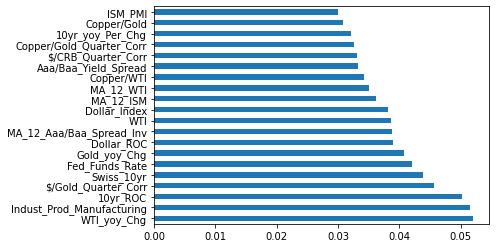

In [ ]:
feature_imp = model_xgb.named_steps['xgbclassifier'] .feature_importances_
features = X_train.columns

pd.Series(feature_imp, features).sort_values(ascending=False).head(20).plot(kind='barh');

In [ ]:
# Taking note of the value_counts() of train and validation set

print(y_train.value_counts())
print(y_val.value_counts())

Decelerate    145
Accelerate    134
Name: CPI_Direction, dtype: int64
Accelerate    20
Decelerate    17
Name: CPI_Direction, dtype: int64


#Split target vector from feature matrix
#Split training, validation, and **test set**

In [ ]:
# target is the `CPI_Direction`

target = 'CPI_Direction'

y = df[target]
X = df.drop(target , axis=1)

In [ ]:
cutoff1 = '2008-07-01'
cutoff2 = '2014-07-01'

mask1 = (df.index <= cutoff1)
mask2 = (df.index > cutoff1) & (df.index < cutoff2)
mask3 = (df.index >= cutoff2)

train = df[mask1]
val = df[mask2]
test = df[mask3]

In [ ]:
y_train = train[target]
X_train = train.drop([target], axis=1)

y_val = val[target]
X_val = val.drop(target, axis=1)

y_test = test[target]
X_test = test.drop(target, axis=1)

In [ ]:
assert df.shape[0] == train.shape[0] + val.shape[0] + test.shape[0]

In [ ]:
# Model with a train, validation, and test set
# Model 5: XGB Regressor

model_xgb1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_jobs=-1, n_estimators=23)
)

model_xgb1.fit(X_train, y_train);

print('Train Accuracy:', model_xgb1.score(X_train, y_train))
print('Validation Accuracy:', model_xgb1.score(X_val, y_val))
print('Test Accuracy:', model_xgb1.score(X_test, y_test))

Train Accuracy: 0.9415204678362573
Validation Accuracy: 0.5070422535211268
Test Accuracy: 0.6216216216216216


In [ ]:
# Taking note of the value_counts() of train and validation set

print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

Decelerate    89
Accelerate    82
Name: CPI_Direction, dtype: int64
Decelerate    39
Accelerate    32
Name: CPI_Direction, dtype: int64
Accelerate    40
Decelerate    34
Name: CPI_Direction, dtype: int64
